In [ ]:
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
from google.colab import files
ratings = files.upload()

ratings = pd.read_csv("tmdb_5000_credits.csv",index_col=0)


Saving tmdb_5000_credits.csv to tmdb_5000_credits (3).csv


In [16]:
print(ratings.head(2))
# Display columns as a list
ratings.columns


                                             title  \
movie_id                                             
19995                                       Avatar   
285       Pirates of the Caribbean: At World's End   

                                                       cast  \
movie_id                                                      
19995     [{"cast_id": 242, "character": "Jake Sully", "...   
285       [{"cast_id": 4, "character": "Captain Jack Spa...   

                                                       crew  
movie_id                                                     
19995     [{"credit_id": "52fe48009251416c750aca23", "de...  
285       [{"credit_id": "52fe4232c3a36847f800b579", "de...  


Index(['title', 'cast', 'crew'], dtype='object')

In [18]:
des=ratings.describe(include='all')
print(des)

           title  cast  crew
count       4803  4803  4803
unique      4800  4761  4776
top     The Host    []    []
freq           2    43    28


In [19]:
from google.colab import files
movies = files.upload()

movies = pd.read_csv("tmdb_5000_movies.csv",index_col=0)

Saving tmdb_5000_movies.csv to tmdb_5000_movies (2).csv


In [23]:
print(movies.head(2))
movies.columns


                                                      genres  \
budget                                                         
237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   

                                               homepage     id  \
budget                                                           
237000000                   http://www.avatarmovie.com/  19995   
300000000  http://disney.go.com/disneypictures/pirates/    285   

                                                    keywords  \
budget                                                         
237000000  [{"id": 1463, "name": "culture clash"}, {"id":...   
300000000  [{"id": 270, "name": "ocean"}, {"id": 726, "na...   

          original_language                            original_title  \
budget                                                                  
237000000                en                                    Avatar   
30

Index(['genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [24]:
des2=movies.describe(include='all')
print(des2)

                               genres                           homepage  \
count                            4803                               1712   
unique                           1175                               1691   
top     [{"id": 18, "name": "Drama"}]  http://www.missionimpossible.com/   
freq                              370                                  4   
mean                              NaN                                NaN   
std                               NaN                                NaN   
min                               NaN                                NaN   
25%                               NaN                                NaN   
50%                               NaN                                NaN   
75%                               NaN                                NaN   
max                               NaN                                NaN   

                   id keywords original_language   original_title  \
count     4803.000

In [25]:
# Merge the datasets on the 'title' column
data = pd.merge(movies, ratings, left_on='title', right_on='title', how='inner')


In [26]:
# Select relevant columns for collaborative filtering
selected_columns = ['title', 'cast', 'crew', 'vote_average', 'vote_count']
data = data[selected_columns]

In [51]:
# Explore the dataset (EDA)
print("Dataset Information:")
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4809 non-null   object 
 1   cast          4809 non-null   object 
 2   crew          4809 non-null   object 
 3   vote_average  4809 non-null   float64
 4   vote_count    4809 non-null   int64  
 5   user          4809 non-null   int16  
dtypes: float64(1), int16(1), int64(1), object(3)
memory usage: 234.8+ KB
None

Descriptive Statistics:
       vote_average    vote_count         user
count   4809.000000   4809.000000  4809.000000
mean       6.092514    690.331670  2399.249532
std        1.193989   1234.187111  1385.801509
min        0.000000      0.000000     0.000000
25%        5.600000     54.000000  1199.000000
50%        6.200000    235.000000  2401.000000
75%        6.800000    737.000000  3600.000000
max       10.000000  13752.000000  4799.000000


In [29]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163471 sha256=4a07d19a0a509d22e7eea7be7918d8e49a3b81bf3e67f4852aad28e4d915395f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [69]:
# Handle missing values
data.dropna(subset=['vote_average'], inplace=True)


In [70]:
# Handle duplicates
data.drop_duplicates(subset=['title'], inplace=True)

In [71]:
# Handle outliers in 'vote_average' column
# Define a reasonable range for ratings (e.g., 0 to 10)
data = data[(data['vote_average'] >= 0) & (data['vote_average'] <= 10)]

In [74]:
# Convert 'cast' and 'crew' columns to lists (assuming they are JSON-like strings)
#data['cast'] = data['cast'].apply(literal_eval)
#data['crew'] = data['crew'].apply(literal_eval)

In [75]:
# Create a Reader object
from surprise import Dataset, Reader
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy
reader = Reader(rating_scale=(0, 10))

In [76]:
# Load data into Surprise Dataset format
data_surprise = Dataset.load_from_df(data[['user', 'title', 'vote_average']], reader)

In [77]:
# Add a synthetic user ID for each movie
data['user'] = data['title'].astype('category').cat.codes


In [78]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data_surprise, test_size=0.25, random_state=42)

In [79]:
# Build the User-Based Collaborative Filtering model
sim_options_user = {'name': 'cosine', 'user_based': True}
model_user = KNNBasic(sim_options=sim_options_user)
model_user.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [80]:
# Build the Item-Based Collaborative Filtering model
sim_options_item = {'name': 'cosine', 'user_based': False}
model_item = KNNBasic(sim_options=sim_options_item)
model_item.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [87]:
from surprise import KNNBasic, SVD, accuracy
# Build the Matrix Factorization (SVD) model
model_svd = SVD()
model_svd.fit(trainset)

In [88]:
# Make predictions on the test set for all models
predictions_user = model_user.test(testset)
predictions_item = model_item.test(testset)
predictions_svd = model_svd.test(testset)


In [89]:
# Evaluate the models
accuracy_user = accuracy.rmse(predictions_user)
accuracy_item = accuracy.rmse(predictions_item)
accuracy_svd = accuracy.rmse(predictions_svd)

RMSE: 0.5390
RMSE: 1.1735
RMSE: 1.1735


In [90]:
from surprise.model_selection import cross_validate, train_test_split
# Perform cross-validation for SVD
cross_val_results_svd = cross_validate(model_svd, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2312  1.1491  1.1811  1.1570  1.2535  1.1944  0.0412  
MAE (testset)     0.8425  0.8002  0.8304  0.8071  0.8514  0.8263  0.0198  
Fit time          0.11    0.09    0.09    0.09    0.09    0.09    0.01    
Test time         0.01    0.01    0.00    0.01    0.01    0.01    0.00    


In [91]:
# Print the cross-validation results for SVD
print("\nCross-validation results for SVD:")
for metric in ['test_rmse', 'test_mae']:
    print(f"{metric}: {cross_val_results_svd[metric].mean()}")


Cross-validation results for SVD:
test_rmse: 1.1943803230373513
test_mae: 0.82631298828125


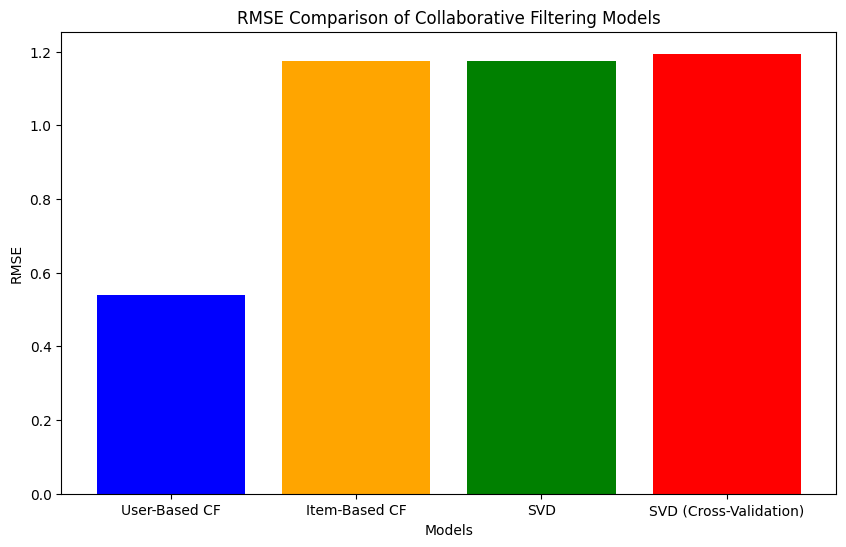

In [93]:
# Plotting the results
import matplotlib.pyplot as plt
models = ['User-Based CF', 'Item-Based CF', 'SVD']
rmse_values = [accuracy_user, accuracy_item, accuracy_svd]
cross_val_rmse_svd = cross_val_results_svd['test_rmse'].mean()

plt.figure(figsize=(10, 6))
plt.bar(models + ['SVD (Cross-Validation)'], rmse_values + [cross_val_rmse_svd], color=['blue', 'orange', 'green', 'red'])
plt.title('RMSE Comparison of Collaborative Filtering Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()